# This notebook provides a number of examples for how Vivarium can combine SBML models using the Bioscrape Simulator

This notebook described how to use Vivarium-Bioscrape to encapsulate Chemical Reaction Network (CRN) models as Vivarium Processes. This allows for CRN models to be run in parallel (including hybrid stochastic/deterministic simulation), coupled with other modeling modalities (such as physics or flux balance).

__Overview:__ 
1. Systems Biology Markup langauge ([SBML](http://sbml.org/Main_Page)) is a file format to represent Chemical Reaction Network Models. The SBML files used in this notebook are generated via [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) in the Example Models notebook.
2. The SBML simulator [Bioscrape](https://github.com/biocircuits/bioscrape) has been wrapped in a Vivarium Process, aptly named Bioscrape.
3. Multiple Bioscrape Processes are connected together by creating a BioscrapeConnector which contains lists of models and the connections between them.
4. Models are connected via an arbitrary translation function stored in the OneWayMap object.
5. The BioscrapeConnector can then be simulated. _Warning: Simulation stability may depend strongly on the global coupling time._

Choosing the correct map between CRN models will, in general, be dependent on the model and desired behavior. This problem can be succintly stated: if speciex $X$ in CRN 1 changes by $\Delta_X$, how should the species in CRN 2 change? The OneWayMap class allows for complete user control over how CRN models communicate by encapsulating an arbitrary python function. A number of common examples of OneWayMaps are given in this notebook including: renaming species, mapping one species to many species and many species to one species, mapping increases and decreases differently, dynamic maps which depend upon the current state, and stochastic to deterministic maps.

In [1]:
%%capture
#Install vivarium_bioscrape from one directory up
!pip install ../

In [2]:
#Imports
from vivarium_bioscrape.processes.bioscrape import Bioscrape
from vivarium_bioscrape.composites.bioscrape_connector import BioscrapeConnector
from vivarium.core.composition import simulate_composite, simulate_composer
import pylab as plt
import numpy as np

# Example 1: one_to_one_mapping

In this example, two species in model 1 will each be linked to a single species in model 4 (two one-to-one mappings)

__Model 1 CRN:__
* $dna\_G \to dna_G + rna\_T$

* $rna\_T \to rna\_T + protein\_X$

__Model 4 CRN:__

* $rna\_RNA \to \emptyset$

* $protein\_Protein \to \emptyset$

Each oneway mapping connects two lists of species such that 
    
    species1[i] = species2[i]

__Mapping 1 $\implies$ 4:__ 

* $rna\_T \implies rna\_RNA$

* $protein\_X \implies protein\_Protein$

__Mapping 4 $\implies$ 1:__ 

* $rna\_RNA \implies rna\_T$

* $protein\_Protein \implies protein\_X$


Simulation ID: adab363a-d2ea-11eb-88f7-6c2b5976b3a5
Created: 06/21/2021 at 16:44:54
Completed in 0.388623 seconds


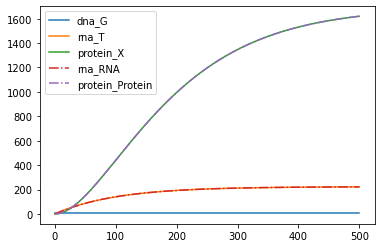

In [3]:
from vivarium_bioscrape.library.mappings import one_to_one_map

#Create Bioscrape Processes
#Model 1: is a simple transcription translation model
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model1.xml'
    })

#Model 4 adds degredation by dilution to proteins and RNAs
bsp2 = Bioscrape(parameters = {
    'sbml_file':'model4.xml'
    })

#Create the map_function using one_to_one_map
#rna_T --> rna_RNA
#proteinX --> protein_Protein
map_func_12 = one_to_one_map(bsp1, bsp2, {'rna_T':'rna_RNA', 'protein_X':'protein_Protein'})

#Create the reverse map_function (which is also a one_to_one_map)
map_func_21 = one_to_one_map(bsp2, bsp1, {'rna_RNA':'rna_T', 'protein_Protein':'protein_X'})

#create a BioscrapeConnector called composite
composer = BioscrapeConnector()

#Add models to the composite
composer.add_model(name = "txtl", bioscrape_process = bsp1)
composer.add_model(name = "dilution", bioscrape_process = bsp2)

#Add connections to the composite
composer.add_connection(source = "txtl", target = "dilution", map_function = map_func_12)
composer.add_connection(source = "dilution", target = "txtl", map_function = map_func_21)

#set the initial state of the dilution model to match the txtl model
dilution_initial_state = {'dilution':{'rna_RNA':0, 'protein_Protein':0}}
initial_state = composer.initial_state(dilution_initial_state)
    
#Run a simulation
sim_settings = {
        'total_time': 500,
        'initial_state': initial_state}
output = simulate_composer(composer, sim_settings)

#Plot results
for s in output['txtl_species']:
    plt.plot(output['time'], output['txtl_species'][s], label = s)
for s in output['dilution_species']:
    plt.plot(output['time'], output['dilution_species'][s], "-.", label = s)
plt.legend();

# Example 2: one_to_many_map and many_to_one_map

In this example, two different RNA and Protein species from model 1b will be mapped to a single RNA and protein Species in model 4. Model 1b is the same as model 1, but with two different genes and transcripts but each transcript produces the same protein.

__Mapping 1b $\implies$ 4:__ 

* $rna\_T1 + rna\_T2\implies rna\_RNA$

* $protein\_X \implies protein\_Protein$

__Mapping 4 $\implies$ 1b:__ 

* $rna\_RNA \implies rna\_T1 + rna\_T2$

* $protein\_Protein \implies protein\_X$


Simulation ID: ae0ba35c-d2ea-11eb-8ac4-6c2b5976b3a5
Created: 06/21/2021 at 16:44:54
Completed in 0.492173 seconds


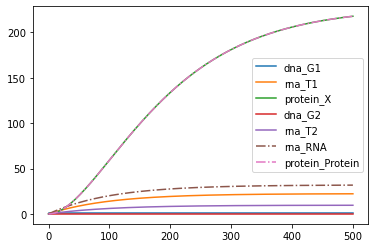

In [4]:
from vivarium_bioscrape.library.mappings import one_to_many_map, many_to_one_map

#Create Bioscrape Processes
#Model 1: is a simple transcription translation model
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model1b.xml'
    })

#Model 4 adds degredation by dilution to proteins and RNAs
bsp2 = Bioscrape(parameters = {
    'sbml_file':'model4.xml'
    })

#Create the map_function using many_to_one_map
#rna_T1 + rna_T2 --> rna_RNA
#protein_X1 + protein_X2 --> protein_Protein
#the many_to_one_map takes the two processes and a dictionary {one_species:[list of many species]}
map_func_12 = many_to_one_map(bsp1, bsp2, {"rna_RNA":["rna_T1", "rna_T2"], 
                               "protein_Protein":['protein_X']})

#Create the reverse map_function one_to_many_map
#rna_RNA --> rna_T1 + rna_T2
#protein_Protein --> protein_X1 + protein_X2
#These species are added proportionally to their concentrations, or evenly if the concentrations are
map_func_21 = one_to_many_map(bsp2, bsp1,  {"rna_RNA":["rna_T1", "rna_T2"], 
                               "protein_Protein":['protein_X']})

#create a BioscrapeConnector called composite
composite = BioscrapeConnector()

#Add models to the composite
composite.add_model(name = "txtl", bioscrape_process = bsp1)
composite.add_model(name = "dilution", bioscrape_process = bsp2)

#Add connections to the composite
composite.add_connection(source = "txtl", target = "dilution", map_function = map_func_12)
composite.add_connection(source = "dilution", target = "txtl", map_function = map_func_21)

#Get the initial state
#set the initial state of the degredation model to match the txtl model
dilution_initial_state = {'rna_RNA':0, 'protein_Protein':0}
txtl_initial_state = {'rna_T1':0, 'rna_T2':0}
initial_state = composite.initial_state({'dilution':dilution_initial_state, 'txtl':txtl_initial_state})
    
#Run a simulation
sim_settings = {
        'total_time': 500,
        'initial_state': initial_state}
output = simulate_composer(composite, sim_settings)

#Plot results
for s in output['txtl_species']:
    plt.plot(output['time'], output['txtl_species'][s], label = s)
for s in output['dilution_species']:
    plt.plot(output['time'], output['dilution_species'][s], "-.", label = s)
plt.legend();

# Example 3: Coupling species with a stochiometric_map

stochiometric_map is a kind of super map, which takes any other map function and a stochiometric dictionary = {species : {coupled species : stochiometric coefficient}}. Any change in the value of species is coupled to the coupled species proprotionally to the stochiometric coefficient.

In the below example, this is used connect model 3 (Transcription Translation, where multiple ribosomes can bind to one RNA) with endonuclease mediated RNA degredation are combined. Stochiometric coupling is used to ensure that when a transcript-ribosome complex is degraded by an endonuclease, the amount of free ribosome increases inversely.

__Model 2: Simple Transcription and Translation with Multiple Occupancy__

$G \rightarrow G + T$

$T:Ribo^{closed}_{n-1} + Ribo \leftarrow \rightarrow T:Ribo^{open}_{n} \leftarrow \rightarrow T:Ribo^{closed}_{n} \rightarrow T + n Ribo + n X$

$T + Ribo \leftarrow \rightarrow T:Ribo^{open}_{1}$


__Model 3: RNA Degredation with Binding__

$T + RNAase \leftarrow \rightarrow T:RNAase \rightarrow RNAase$

_In the final plot, the total amount of ribosome (black) remains constant!_


Simulation ID: ae802d82-d2ea-11eb-b15f-6c2b5976b3a5
Created: 06/21/2021 at 16:44:55
Completed in 0.251256 seconds


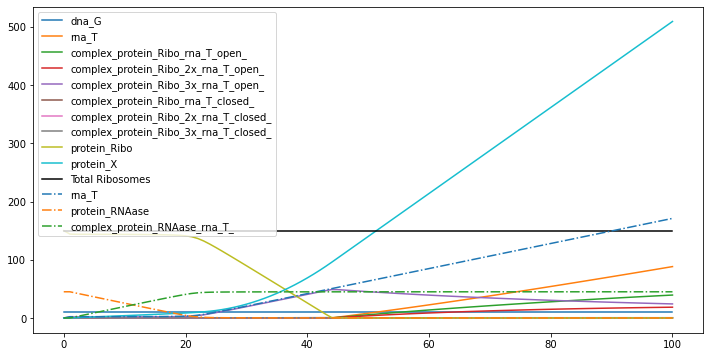

In [5]:
from vivarium_bioscrape.library.mappings import stochiometric_map, det_to_stoch_map, stoch_to_det_map

#Create Bioscrape Processes
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model2.xml'
    })

bsp2 = Bioscrape(parameters = {
    'sbml_file':'model3.xml'
    })

#Create the map_function using many_to_one_map
rna_species_1 = [s for s in bsp1.get_model_species_ids() if "rna_T" in s]
map_func_12 = many_to_one_map(bsp1, bsp2, {"rna_T":rna_species_1})

#Create the reverse map_function with stochiometric constraints

#First create a one_to_many parent map function
parent_map_func_21 = one_to_many_map(bsp2, bsp1,  {"rna_T":rna_species_1})

#Then create the stochiometric_map

#Helper function to count the number of ribosomes in a complex
def ribo_count(s):
    count = 0
    if "x_rna" in s:
        ind = s.index('x_rna')
        count = int(s[ind-1])
    elif "protein_Ribo" in s:
         count = 1
    else:
        count = 0
    return count

#Every time a RNA-ribosome complex is degraded, a number of protein_Ribo are produced
stoch_dict = {s:{'protein_Ribo': -ribo_count(s)} for s in rna_species_1}

#Use the stoch_dict and the parent_map_func to create the full map_function
map_func_21 = stochiometric_map(parent_map_func_21, stoch_dict)

#create a BioscrapeConnector called composite
composite = BioscrapeConnector()

#Add models to the composite
composite.add_model(name = "txtl", bioscrape_process = bsp1)
composite.add_model(name = "degradation", bioscrape_process = bsp2)

#Add connections to the composite
composite.add_connection(source = "txtl", target = "degradation", map_function = map_func_12)
composite.add_connection(source = "degradation", target = "txtl", map_function = map_func_21)

#Get the initial state
initial_state = composite.initial_state({'txtl' : {'rna_T':0}, "degradation": {'rna_T':0}})
    
#Run a simulation
sim_settings = {
        'total_time': 100,
        'initial_state': initial_state}
output = simulate_composer(composite, sim_settings)

#Plot results
plt.figure(figsize = (12, 6))
total_ribo = np.zeros(len(output['time']))
for s in output['txtl_species']:
    plt.plot(output['time'], output['txtl_species'][s], label = s)
    #Calculate total amount of ribosome
    total_ribo += np.array(output['txtl_species'][s])*ribo_count(s)

plt.plot(output['time'], total_ribo, color = "black", ms = 4, label = "Total Ribosomes")
for s in output['degradation_species']:
    plt.plot(output['time'], output['degradation_species'][s], "-.", label = s)

plt.legend();

# Example 4: Connecting Deterministic and Stochastic Simulations
Bioscrape and the Vivarium Bioscrape Process can do either stochastic or deterministic simulation.

__Stochastic Model of Transcription:__ 

Transcription is modeled with binding of a polymerase $P$ to the gene $G$ which produces a trascript $T$

$G + P \leftrightarrow G:P \to G + P + T$

__Deterministic Model of Translation and Dilution:__

Translation is modeled with binding of a ribosome $R$ to the transcript $T$ which produces a protein $X$

$T + R \leftrightarrow T:R \to T + R + X$

Dilution of the transcript and protein
$T \to \emptyset \quad X \to \emptyset$


Simulation ID: aee59370-d2ea-11eb-911b-6c2b5976b3a5
Created: 06/21/2021 at 16:44:56
Completed in 2.24 seconds


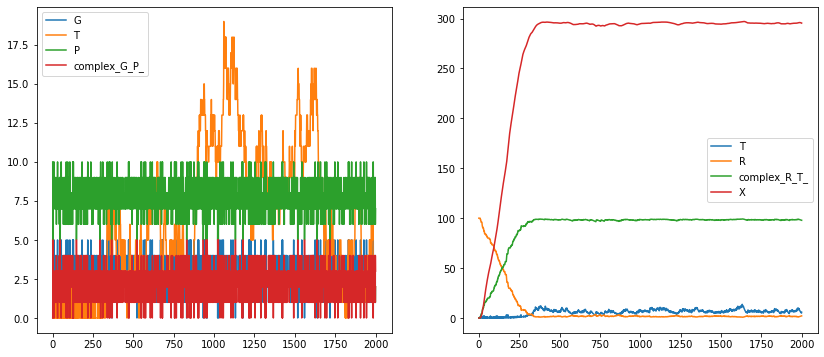

In [6]:
from vivarium_bioscrape.library.mappings import det_to_stoch_map, stoch_to_det_map

from vivarium_bioscrape.library.mappings import one_to_one_map

#Create Bioscrape Processes
#Model 5: is a stochastic transcription model
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model5.xml',
    'stochastic':True,
    'initial_volume':1.0,
    'time_step':1
    })

#Model 6 is a model of translation and dilution
#This model is deterministic
bsp2 = Bioscrape(parameters = {
    'sbml_file':'model6.xml',
    'initial_volume':1.0,
    'time_step':1
    })

#Create the parent map_function using one_to_one_map
map_func_12_parent = one_to_one_map(bsp1, bsp2, {'T':'T'})

#put the parent function into a stoch_to_det_map
map_func_12 = stoch_to_det_map(map_func_12_parent)

#Create the reverse map_function (which is also a one_to_one_map)
map_func_21_parent = one_to_one_map(bsp2, bsp1, {'T':'T'})

#put the parent function into a det_to_stoch_map
map_func_21 = det_to_stoch_map(map_func_21_parent)

#create a BioscrapeConnector called composite
composite = BioscrapeConnector()

#Add models to the composite
composite.add_model(name = "tx", bioscrape_process = bsp1)
composite.add_model(name = "tl_dil", bioscrape_process = bsp2)

#Add connections to the composite
composite.add_connection(source = "tx", target = "tl_dil", map_function = map_func_12)
composite.add_connection(source = "tl_dil", target = "tx", map_function = map_func_21)

#Get the initial state
initial_state = composite.initial_state({
    "tx":{"G":5.0, "P":10},
    "tl_dil":{"R":100}})
    
#Run a simulation
sim_settings = {
    'total_time': 2000,
    'initial_state': initial_state,
    'progress_bar':False}
output = simulate_composer(composite, sim_settings)

#Plot results
plt.figure(figsize = (14, 6))
plt.subplot(121)
for s in output['tx_species']:
    plt.plot(output['time'], output['tx_species'][s], label = s)
plt.legend()

plt.subplot(122)
for s in output['tl_dil_species']:
    plt.plot(output['time'], output['tl_dil_species'][s], label = s)
plt.legend()